In [6]:
%load_ext autoreload
%autoreload 2
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()

# Local imports
from src.api_call import *
from src.utils.hydropower_potential import *
from src.utils.PyGeoTools.geolocation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'src'

# Download data from the USGS Water Services API

The method `get_data` allows for programatically download of stream flow data from the USGS Water Services API. The input data for the method is the site identification and the range of dates. The inputs should be specified in a dictionary as it is shown below. Several options exist to pull data such as site id, HUC number (it returns all the stream gauges available in the HUC), and a coordinate bounding box. The example below focuses on pulling data for one site using the `site_id`. The user can opt for not saving the data on a file -- unlike the example where it is shown how to save the data in a csv. The `get_data` method always returns a list of pandas dataframes regardless of the number of sites requested. In the example below, that means that `flow_info` will be a list with one element, which is a dataframe.

In [19]:
query = {}
query['id'] = '11370500'
query['start_date'] = '2010-01-01'
query['end_date'] = '2020-12-31'

# Call the get_data method. Note that the id_type has been set to 'sites'
flow_info = get_data(query, id_type='sites', save_data=True, path='/Users/galljf/Desktop/11370500_shiloh.csv')

https://waterservices.usgs.gov/nwis/iv/?format=json&sites=11370500&startDT=2010-01-01&endDT=2020-12-31&parameterCd=00060&siteStatus=all
Success with data retrieval from API


Inside `get_data`, other process take place in addition to just downloading the data. The data comes in `json` format, so the tool formats it and saves it as a dataframe. By default, the header of the stream flow data come as `Streamflow, ft&#179;/s` as seen below. In addition, a timestamp is added along with coordinate information and qualifiers for the data. The latter are set by USGS and can be used for further data quality

In [20]:
flow_info[0].head()

,"Streamflow, ft&#179;/s",qualifiers,dateTime,site_name,site_id,lat,long
0,3260,[A],2010-01-01T00:00:00.000-08:00,SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
1,3270,[A],2010-01-01T00:15:00.000-08:00,SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
2,3250,[A],2010-01-01T00:30:00.000-08:00,SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
3,3270,[A],2010-01-01T00:45:00.000-08:00,SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
4,3270,[A],2010-01-01T01:00:00.000-08:00,SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455


In [32]:
# Clean the data and make the date time column the index 
flow_info_temp = clean_data(flow_info[0], column_change={'Streamflow, ft&#179;/s':'discharge_cfs'}, keep_nan=True, timestamp_col='dateTime', no_data=-999999)

In [33]:
flow_info_temp.head()

,discharge_cfs,qualifiers,site_name,site_id,lat,long
dateTime,,,,,,
2010-01-01 08:00:00+00:00,3260.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
2010-01-01 08:15:00+00:00,3270.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
2010-01-01 08:30:00+00:00,3250.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
2010-01-01 08:45:00+00:00,3270.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455
2010-01-01 09:00:00+00:00,3270.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455


In [58]:
flow_info_temp.drop(columns=['qualifiers','site_name','lat','long'], inplace=True)

In [59]:
flow_info_temp.head()

,discharge_cfs,site_id
dateTime,,
2010-01-01 08:00:00+00:00,3260.0,11370500
2010-01-01 08:15:00+00:00,3270.0,11370500
2010-01-01 08:30:00+00:00,3250.0,11370500
2010-01-01 08:45:00+00:00,3270.0,11370500
2010-01-01 09:00:00+00:00,3270.0,11370500


In [60]:
# Calculate the hydropower potential
turbine = calculate_potential(flow_info_temp, rated_flow=0, rated_power=0, head_input=500, system='pipe', flow_column='discharge_cfs')

In [53]:
turbine_power = flow_info_temp.copy()
turbine_power['power (MW)'] = turbine.power
turbine_power['efficiency (%)'] = turbine.effi_cal

In [56]:
turbine_power.head()

/Users/galljf/OneDrive - Idaho National Laboratory/code/hat/hat/utils/hydropower_potential.py:172: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
  self.effi_cal = (1-1.25((peak_eff_flow - self.flow_range)/peak_eff_flow)**1.13)*peak_eff


,discharge_cfs,qualifiers,site_name,site_id,lat,long,power (MW),efficiency (%)
dateTime,,,,,,,,
2010-01-01 08:00:00+00:00,3260.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455,0.0,0.0
2010-01-01 08:15:00+00:00,3270.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455,0.0,0.0
2010-01-01 08:30:00+00:00,3250.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455,0.0,0.0
2010-01-01 08:45:00+00:00,3270.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455,0.0,0.0
2010-01-01 09:00:00+00:00,3270.0,[A],SACRAMENTO R A KESWICK CA,11370500,40.600983,-122.444455,0.0,0.0


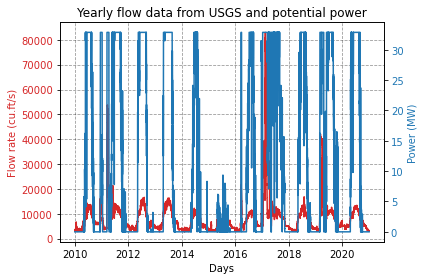

In [54]:
df = turbine_power.copy()
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Flow rate (cu.ft/s)', color=color)
ax1.plot(df['discharge_cfs'], label="Flow rate", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Power (MW)', color=color)  # we already handled the x-label with ax1
ax2.plot(df['power (MW)'],'b-',label="Power", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='both', color='k',linestyle='--',alpha=0.4)
plt.title("Yearly flow data from USGS and potential power")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig(os.path.join('..','fig','usgs_twin_falls_flow_power.jpg'))
plt.show()

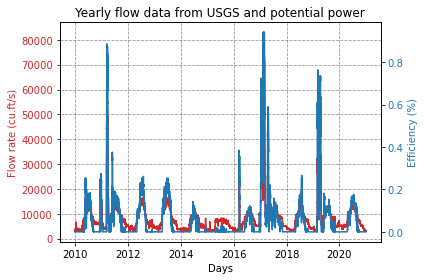

In [55]:
df = turbine_power.copy()
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Days')
ax1.set_ylabel('Flow rate (cu.ft/s)', color=color)
ax1.plot(df['discharge_cfs'], label="Flow rate", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Efficiency (%)', color=color)  # we already handled the x-label with ax1
ax2.plot(df['efficiency (%)'],'b-',label="Power", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='both', color='k',linestyle='--',alpha=0.4)
plt.title("Yearly flow data from USGS and potential power")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig(os.path.join('..','fig','usgs_twin_falls_flow_power.jpg'))
plt.show()